In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import powerlaw
import networkx as nx
import pickle as pkl
import community as community_louvain
from collections import Counter
import random

In [3]:
unipartite = pd.read_csv('../shared-folder-gald/data/edgelist_unipartite.csv')

In [4]:
unipartite

,Source,Target,Weight
0,democraticrepublicans,lewisandclark,1
1,democraticrepublicans,johnadams,1
2,democraticrepublicans,apgovernment,1
3,democraticrepublicans,usconstitution,1
4,democraticrepublicans,barbarypirates,1
...,...,...,...
35570521,iuictv,iuicnigeria,1
35570522,面白い動画,lion,1
35570523,coolartwork,lion,2
35570524,bridalmakeup,fridayfashionfreestyle,1


In [5]:
unique_nodes = pd.unique(pd.concat([unipartite['Source'], unipartite['Target']])).size
print(f"Total unique nodes: {unique_nodes}")


Total unique nodes: 673090


In [7]:
max_weight = unipartite['Weight'].max()
print(f"Max weight: {max_weight}")


Max weight: 47946


In [11]:
count_weight_1 = unipartite[unipartite['Weight'] == 1].shape[0]
print(f"Number of entries with weight=1: {count_weight_1}")


Number of entries with weight=1: 24597785


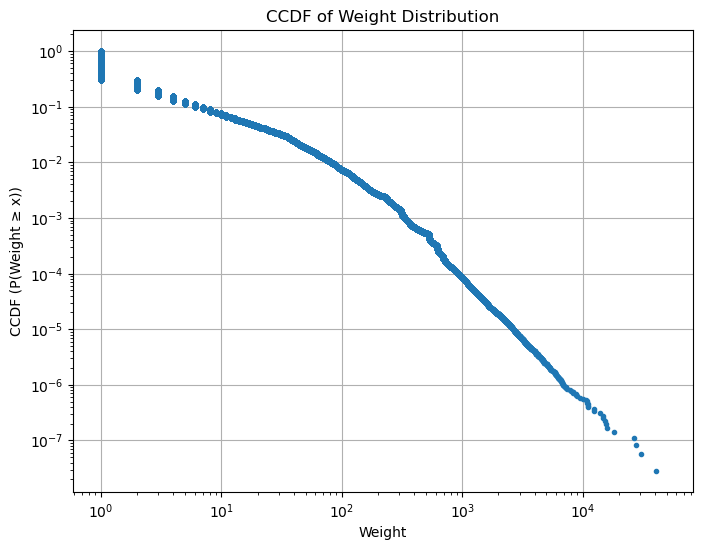

In [13]:

weights = unipartite['Weight']

# Sort weights in ascending order
sorted_weights = np.sort(weights)

# Calculate CCDF: proportion of weights >= each value
ccdf = 1.0 - np.arange(1, len(sorted_weights) + 1) / len(sorted_weights)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(sorted_weights, ccdf, marker='.', linestyle='none')
plt.xlabel('Weight')
plt.ylabel('CCDF (P(Weight ≥ x))')
plt.title('CCDF of Weight Distribution')
plt.yscale('log')  # Optional: log scale for better visibility if tail is heavy
plt.xscale('log')  # Optional: log scale for x if weight has a wide range
plt.grid(True)
plt.show()


In [ ]:
#this runs for a long time

weights = unipartite['Weight']

# Fit the power law model
fit = powerlaw.Fit(weights, xmin=np.min(weights))

# Get the alpha (power law exponent) and the minimum value from where the power law holds
print(f"Alpha: {fit.alpha}")
print(f"Xmin: {fit.xmin}")

# Compare power law against other distributions
distribution_list = ['lognormal', 'exponential', 'truncated_power_law', 
      'stretched_exponential', 'lognormal_positive']

for distribution in distribution_list:
    R, p = fit.distribution_compare('power_law', distribution) #A positive R implies the Power Law is a better fit, while a negative R implies the alternative distribution is better.
    print("power law vs " + distribution + 
          ": R = " + str(np.round(R,3)) + 
          ", p = " + str(np.round(p,3)))
    
# power law vs lognormal: R = 34296.196, p = 0.0
# power law vs exponential: R = 56529196.218, p = 0.0
# Assuming nested distributions
# power law vs truncated_power_law: R = 0.024, p = 0.825
# power law vs stretched_exponential: R = 2671318.95, p = 0.0
# power law vs lognormal_positive: R = 18001915.916, p = 0.0

Alpha: 2.941328551286547
Xmin: 1.0


/Users/renatasapeta/anaconda3/lib/python3.11/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


power law vs lognormal: R = 34296.196, p = 0.0
power law vs exponential: R = 56529196.218, p = 0.0


Assuming nested distributions


power law vs truncated_power_law: R = 0.024, p = 0.825
power law vs stretched_exponential: R = 2671318.95, p = 0.0
power law vs lognormal_positive: R = 18001915.916, p = 0.0


In [ ]:
G = nx.Graph()
with open('../shared-folder-gald/data/graph.pkl', 'rb') as f:
    G = pkl.load(f)

In [14]:
largest_component = max(nx.connected_components(G), key=len)

In [ ]:
#runs for a long time

GCC = G.subgraph(largest_component).copy()

In [16]:
GCC.number_of_nodes()

671514

In [17]:
nx.density(GCC)

0.00015775118521048348

In [18]:
# Start with an initial k-value and increase to reduce network size
k = 5  # We want to show let's say 5 related hashtags 
G_k_core = nx.k_core(GCC, k=k)

print(f"K-core with k={k}: {G_k_core.number_of_nodes()} nodes, {G_k_core.number_of_edges()} edges")


K-core with k=5: 641826 nodes, 35479844 edges


In [19]:
nx.density(G_k_core)

0.00017225734996768945

In [ ]:
# with open("k_core.pkl", "wb") as f:
#     pkl.dump(G_k_core, f)

In [2]:
with open("k_core.pkl", "rb") as f:
    G_k_core = pkl.load(f)

In [24]:
pip install python-louvain


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.6/204.6 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9389 sha256=c11bd1a4b17453e7726b53d48811cd180c0834de20a5f57f7a6c246499d97319
  Stored in directory: /Users/renatasapeta/Library/Caches/pip/wheels/11/c1/e7/f62a211c636275e2da798bf0c307a3ae79aeddaf2524a03ce4
Successfully built python-louvain
Note: you may need to restart the kernel to use updated packages.


In [3]:


# Detect communities
partition = community_louvain.best_partition(G_k_core)

# Count nodes per community
community_sizes = Counter(partition.values())

# Compute total number of nodes in the graph
total_nodes = len(G_k_core.nodes())

# Target number of nodes
target_nodes = 190000

# Calculate the fraction of nodes to keep based on the target size
sampling_fraction = target_nodes / total_nodes

# Select nodes based on fraction from each community
selected_nodes = set()

for com, size in community_sizes.items():
    # Get all nodes in the current community
    community_nodes = [node for node, comm in partition.items() if comm == com]
    
    # Calculate number of nodes to select from this community
    num_to_select = int(len(community_nodes) * sampling_fraction)
    
    # Randomly sample nodes from the community
    selected_nodes.update(random.sample(community_nodes, num_to_select))
    
    # Stop when we reach the target number of nodes
    if len(selected_nodes) >= target_nodes:
        break

# Create the subgraph with the selected nodes
G_reduced = G.subgraph(selected_nodes).copy()

print(f"Reduced network: {G_reduced.number_of_nodes()} nodes, {G_reduced.number_of_edges()} edges")


NameError: name 'G' is not defined

In [4]:
# Create the subgraph with the selected nodes
G_reduced = G_k_core.subgraph(selected_nodes).copy()

print(f"Reduced network: {G_reduced.number_of_nodes()} nodes, {G_reduced.number_of_edges()} edges")

Reduced network: 189958 nodes, 3043510 edges


In [ ]:
# with open("G_reduced.pkl", "wb") as f:
#     pkl.dump(G_reduced, f)